In [8]:
import torch 
from torch.utils.data import DataLoader 
from tqdm import tqdm 
import numpy as np
from typing import List, Optional, Tuple
from stedfm import get_pretrained_model_v2
from stedfm.DEFAULTS import BASE_PATH 
from stedfm.loaders import get_dataset 
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

DATASET = "optim"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
GLOBAL_POOL = "avg"


def get_classes(dataset: str):
    if dataset == "optim":
        return ["Actin", "Tubulin", "CaMKII", "PSD95"]  
    elif dataset == "neural-activity-states":
        return ["Block", "0Mg", "GluGly", "48hTTX"]
    elif dataset == "peroxisome":
        return ["4hMeOH", "6hMeOH", "8hMeOH", "16hMeOH"]
    elif dataset == "polymer-rings":
        return ["CdvB1", "CdvB2"]
    elif dataset == "dl-sim":
        return ["adhesion", "factin", "microtubule", "mitosis"]
    else:
        raise ValueError(f"Dataset {dataset} not supported")
    
CLASSES = get_classes(DATASET)
N_CLASSES = len(CLASSES)


In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running on {DEVICE} ---")

model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0,
    pretrained=True if "imagenet" in WEIGHTS.lower() else False,
    in_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
model.to(DEVICE)
model.eval()

--- Running on cuda ---
mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- ViT case with none-ImageNet weights or from scratch ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


In [10]:
_, _, test_loader = get_dataset(
    name=DATASET,
    transform=None,
    training=True,
    path=None,
    batch_size=cfg.batch_size,
    n_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
)

/home-local/Frederic/evaluation-data/optim_train
Train dataset size: 1536 --> (array([0, 1, 2, 3]), array([881, 220, 208, 227]))
Valid dataset size: 147 --> (array([0, 1, 2, 3]), array([82, 29, 16, 20]))
Test dataset size: 438 --> (array([0, 1, 2, 3]), array([261,  60,  56,  61]))


In [ ]:
import matplotlib.pyplot as plt 
from timm.models.layers import PatchEmbed 
import torch.nn.functional as F
from tiffwrapper import make_composite

def show_amap(image, a_map):
    image = image.squeeze().cpu().data.numpy()
    a_map = a_map.squeeze().cpu().data.numpy()
    if image.ndim == 3:
        image = image[0]

    m, M = np.min(image), np.max(image)
    image_rgb = make_composite(np.array([image]), luts=["gray"], ranges=[(m, M)])
    image_amap_rgb = make_composite(np.stack([image, a_map]), luts=["gray", "Orange Hot"], ranges=[(m, M), (a_map.min() + 0.25 *(a_map.max() - a_map.min()), a_map.max())])

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(image_amap_rgb)
    ax.axis("off")
    plt.show()

N = len(test_loader.dataset)
indices = np.arange(N)
np.random.shuffle(indices)

feature_extractor = create_feature_extractor(
    model, return_nodes=["backbone.blocks.11.attn.q_norm", "backbone.blocks.11.attn.k_norm"],
    tracer_kwargs={'leaf_modules': [PatchEmbed]}
)


with torch.no_grad():
    xs = np.arange(0, 224, 16)
    print(indices[0])
    for i in [272]:
        # fig = plt.figure(figsize=(10, 10))
        # ax = fig.add_subplot(111)
        # img = test_loader.dataset[i][0].unsqueeze(0).to(DEVICE)
        img = test_loader.dataset[i][0].squeeze().cpu().numpy()
        np.save("./img.npy", img)
        # out = feature_extractor(img)
        # q, k = out["backbone.blocks.11.attn.q_norm"], out["backbone.blocks.11.attn.k_norm"]
        # factor = (384 / 6) ** -0.5 # (head_dim / num_heads ) ** -0.5
        # q = q * factor 
        # attn = q @ k.transpose(-2, -1) # (1, 6, 197, 197)
        # attn = attn.softmax(dim=-1) # (1, 6, 197, 197) 
        # head = np.random.randint(0, 6)
        # attn_map = attn[:, head, :, :].squeeze(0)
        # for head in range(6):
        #     print(head)
        #     cls_attn_map = attn[:, :, 0, 1:]  # (1, 6, 196) 
        #     cls_attn_map = cls_attn_map[:, head, :].view(14, 14).detach() # (14, 14)
        #     cls_resized = F.interpolate(cls_attn_map.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1) # (224, 224, C)
        #     m, M = cls_resized.min(), cls_resized.max()
        #     cls_resized = (cls_resized - m) / (M - m)
        #     show_amap(img, cls_resized)
        # img = test_loader.dataset[i][0].squeeze().cpu().numpy()
        # ax.imshow(img, cmap="hot")
        # ax.set_title(i)
        # for x in xs:
        #     ax.axvline(x, color="white", linewidth=1.0)
        #     ax.axhline(x, color="white", linewidth=1.0)

    #     ax.axis("off")
    #     plt.show()
    #     plt.close(fig)
    # fig.savefig("./patchified_img.png", dpi=1200, bbox_inches="tight")

404


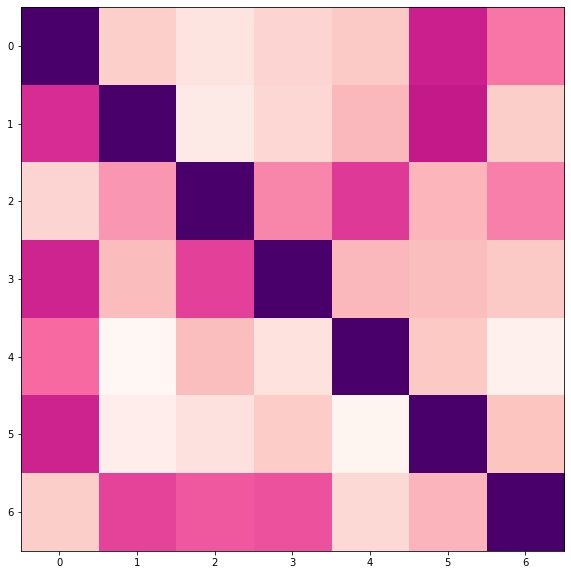

In [48]:
mat = np.random.rand(7,7)
mat *= 0.7
np.fill_diagonal(mat, 1.0)
fig = plt.figure(figsize=(10,10))
plt.imshow(mat, cmap="RdPu")
plt.show()

In [118]:
embeddings, labels, dataset_idx = [], [], []
N = len(test_loader.dataset)
with torch.no_grad():
    for i in range(N):
        img = test_loader.dataset[i][0].unsqueeze(0)
        metadata = test_loader.dataset[i][1]
        img = img.to(DEVICE)
        label = metadata["label"]
        d_id = metadata["dataset-idx"]
        output = model.forward_features(img)
        embeddings.append(output)
        labels.append(label)
        dataset_idx.append(d_id)

embeddings = torch.cat(embeddings, dim=0)
labels = np.array(labels)
dataset_idx = np.array(dataset_idx)
print(embeddings.shape, labels.shape)
assert embeddings.shape[0] == labels.shape[0]

torch.Size([1242, 384]) (1242,)


In [119]:
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import trange


num_repetitions = 50
num_samples = 30
rep_accuracies = []
for n in trange(embeddings.shape[0]):
    random_embedding = embeddings[n]
    target_label = labels[n]
    img = test_loader.dataset[n][0].squeeze().cpu().numpy()
    img = img[0] if "imagenet" in WEIGHTS.lower() else img
    similarities = F.cosine_similarity(embeddings, random_embedding.unsqueeze(0), dim=1).cpu().numpy()
    sorted_indices = np.argsort(similarities)[::-1]
    query_labels = []

    for i in sorted_indices[1:num_samples+1]:
        sim = similarities[i]
        data_index = dataset_idx[i]
        similar_img = test_loader.dataset[data_index][0].squeeze().cpu().numpy()
        query_labels.append(labels[i])
        similar_img = similar_img[0] if "imagenet" in WEIGHTS.lower() else similar_img
        # if labels[i] != target_label:
        #     fig, axs = plt.subplots(1, 2)
        #     axs[0].imshow(img, cmap='hot')
        #     axs[1].imshow(similar_img, cmap='hot')
        #     axs[1].set_title(f"Similarity: {sim:.2f}")
        #     for ax in axs:
        #         ax.axis('off')
        #     plt.show()

    retrieval_accuracy = np.sum(np.array(query_labels) == target_label) / len(query_labels)
    rep_accuracies.append(retrieval_accuracy)

print(f"Average retrieval accuracy: {np.mean(rep_accuracies):.2f} ± {np.std(rep_accuracies):.2f}")



100%|██████████| 1242/1242 [00:30<00:00, 40.60it/s]

Average retrieval accuracy: 0.88 ± 0.22
